In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compared numpy based normalize vs torchvision.transforms.normalize 

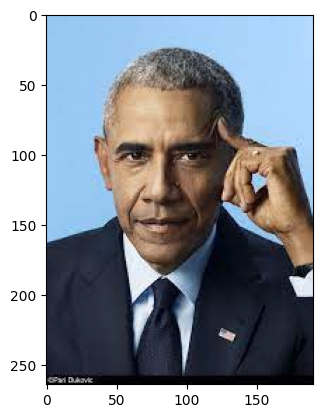

In [2]:
img = cv2.imread('image.jpg') / 255.0
img = img[:, :, ::-1] # (BGR to RGB)
plt.imshow(img)

In [8]:
img_mean=np.array([0.485, 0.456, 0.406]).reshape(1,1,-1)
img_std=np.array([0.229, 0.224, 0.225]).reshape(1,1,-1)

import time
t0 = time.perf_counter()
for i in range(100):
    img_resize = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    simul_norm_img = (img_resize - img_mean) / img_std
t1 = time.perf_counter()
print(f"re-normalize operation : {(t1 - t0) / 100:.3f} sec")

simul_norm_tensor = torch.from_numpy(simul_norm_img.transpose(2,0,1))

import torch
from torchvision import transforms

torch_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = torch.from_numpy(img_resize.transpose(2,0,1).copy())
torch_norm_tensor = torch_norm(img_tensor)
print("norm error : ", (simul_norm_tensor - torch_norm_tensor).sum())

re-normalize operation : 0.002 sec
norm error :  tensor(0., dtype=torch.float64)


## Generate ResNet based RepVGGNet

In [58]:
import timm
import torch.nn as nn
net = timm.create_model('resnet18', pretrained=True)

class SixDofNet(nn.Module):
    def __init__(self, model_name, pretrained  ):
        super(SixDofNet, self).__init__()
        try:
            self.net = timm.create_model(model_name, pretrained=pretrained)
        except:
            assert False, f"model name ({model_name}) does not support timm model"
        
        if 'resnet' in model_name:
            fea_dim = self.net.fc.in_features
            self.net.fc = nn.Linear(fea_dim, 6)
        elif 'mobilenet' in model_name:
            fea_dim = self.net.classifier.in_features
            self.net.classifier = nn.Linear(fea_dim, 6)
        else:
            assert False, f"SixDofNet support resnet or mobilenet"
    
    def forward(self, x):
        output = self.net(x)
        return output

In [59]:
img_size = torch.randn(1,3,112,112)

sixdresnet = SixDofNet('resnet18', pretrained=True)
sixdresnet(img_size).shape

torch.Size([1, 6])